# Fit a model to observations

In the **Quickstart example** notebook we saw a quick introduction to forward modeling the upper atmosphere and He triplet signal of HD 209458 b. In this notebook we will go over an advanced-level tutorial on retrieving the properties of the upper atmosphere of HAT-P-11 b using ``p-winds`` models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.constants as c
import astropy.units as u
from astropy.convolution import convolve
from scipy.optimize import minimize
from p_winds import parker, hydrogen, helium, transit, lines, tools

# Uncomment the next line if you have a MacBook with retina screen
# %config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 9.0,6.5
pylab.rcParams['font.size'] = 18

In [51]:
x = np.arange(-10, 10, 0.01)

In [74]:
y = 1.0 - 0.1*np.exp(-(x)**2/3.0**2)

yp = 1.0 - 0.2*np.exp(-(x+2)**2/1.8**2)

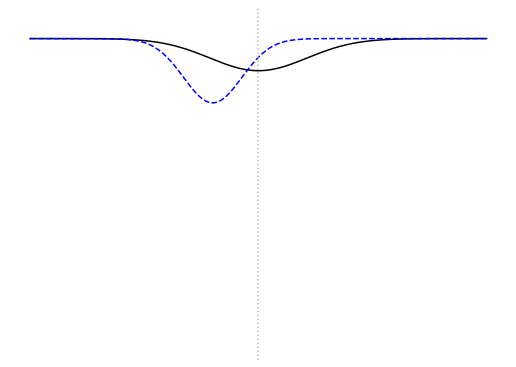

In [75]:
fig, ax = plt.subplots()
ax.plot(x, y, color='k')
ax.plot(x, yp, color='b', linestyle='dashed')
ax.axvline(0, color='#bbbbbb', linestyle='dotted')

ax.set_ylim(0, 1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.savefig('../../figures/interplay_vsini4.pdf', bbox_inches='tight')

Let's start with the observation of the He triplet transmission spectrum of HAT-P-11 b using the CARMENES spectrograph. This data is openly available in the [DACE platform](https://dace.unige.ch/openData/). But we will retrieve it from a [public Gist](https://gist.github.com/ladsantos/a8433928e384819a3632adc469bed803) for convenience.

In [2]:
# The observed transmission spectrum
data_url = 'https://gist.githubusercontent.com/ladsantos/a8433928e384819a3632adc469bed803/raw/a584e6e83073d1ad3444248624927838588f22e4/HAT-P-11_b_He.dat'
# We skip 2 rows instead of 1 to have an odd number of rows and allow a fast convolution later
He_spec = np.loadtxt(data_url, skiprows=2)
wl_obs = He_spec[:, 0]  # Angstrom
f_obs = 1 - He_spec[:, 1] * 0.01  # Normalized flux
u_obs = He_spec[:, 2] * 0.01  # Flux uncertainty

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../../data/HPF/pwinds_fake_signal_100snr_3e13gps.csv')

In [5]:
wl_obs = df.wl.values
f_obs = df.noisy_signal.values
u_obs = 0.01*np.ones_like(f_obs)

In [6]:
# Convert in-vacuum wavelengths to in-air
#s = 1E4 / np.mean(wl_obs)
#n = 1 + 0.0000834254 + 0.02406147 / (130 - s ** 2) + 0.00015998 / (38.9 - s ** 2)
#wl_obs /= n

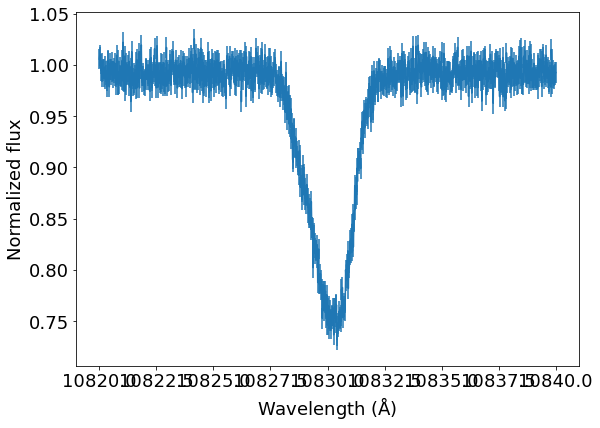

In [7]:
# We will also need to know the instrumental profile that
# widens spectral lines. We take the width from Allart et al. (2018),
# the paper describing the HAT-P-11 b data.
def gaussian(x, mu=0.0, sigma=1.0):
    return 1 / sigma / (2 * np.pi) ** 0.5 * np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

instrumental_profile_width_v = 3.7  # Instrumental profile FWHM in km / s (assumed Gaussian)
sigma_wl = instrumental_profile_width_v / (2 * (2 * np.log(2)) ** 0.5) / \
    c.c.to(u.km / u.s).value * np.mean(wl_obs)  # Same unit as wl_obs
instrumental_profile = gaussian(wl_obs, np.mean(wl_obs), sigma=sigma_wl)

plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()

Now we set up the simulation. This is quite a dense cell of configurations, but you should be familiar with all of it if you followed the quickstart example.

In [8]:
# HAT-P-67 b planetary parameters, measured
R_pl = 2.085  # Planetary radius in Jupiter radii
M_pl = 0.34  # Planetary mass in Jupiter masses
impact_parameter = 0.04  # Transit impact parameter
a_pl = 0.065  # Orbital semi-major axis in astronomical units

# HAT-P-67 b stellar parameters
R_star = 2.546  # Stellar radius in solar radii
M_star = 1.642  # Stellar mass in solar masses

In [10]:
initial_f_ion = 0.0
r = np.logspace(0, np.log10(70), 500)  # Radial distance profile in unit of planetary radii

In [12]:
# First convert everything to SI units because they make our lives
# much easier.
R_pl_physical = R_pl * 71492000  # Planet radius in m
r_SI = r * R_pl_physical  # Array of altitudes in m
planet_to_star_ratio = 0.0834

In [13]:
# Set up the simulation
h_fraction = 0.90  # H number fraction
he_fraction = 1 - h_fraction  # He number fraction
he_h_fraction = he_fraction / h_fraction
mean_f_ion = 0.90  # Initially assumed, but the model relaxes for it
mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)  
# mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

# Physical constants
m_h = c.m_p.to(u.g).value  # Hydrogen atom mass in g
m_He = 4 * 1.67262192369e-27  # Helium atomic mass in kg
k_B = 1.380649e-23  # Boltzmann's constant in kg / (m / s) ** 2 / K

# Free parameters (to be sampled with the optimization algorithm)
# The reason why we set m_dot and T in log is because
# we will fit for them in log space
log_m_dot_0 = np.log10(3E13)  # Planetary mass loss rate (g / s)
log_T_0 = np.log10(9100)  # Atmospheric temperature (K)
v_wind_0 = -2E3  # Line-of-sight wind velocity (m / s)

# Altitudes samples (this can be a very important setting)
#r = np.logspace(0, np.log10(20), 100)

# First guesses of fractions (not to be fit, but necessary for the calculation)
initial_f_ion = 0.0  # Fraction of ionized hydrogen
initial_f_he = np.array([1.0, 0.0])  # Fraction of singlet, triplet helium

# Model settings
relax_solution = True  # This will iteratively relax the solutions until convergence
exact_phi = True  # Exact calculation of H photoionization
sample_phases = np.linspace(-0.50, 0.50, 5)  # Phases that we will average to obtain the final spectrum
# The phases -0.5 and +0.5 correspond to the times of first and fourth transit contact
w0, w1, w2, f0, f1, f2, a_ij = lines.he_3_properties()
w_array = np.array([w0, w1, w2])  # Central wavelengths of the triplet
f_array = np.array([f0, f1, f2])  # Oscillator strengths of the triplet
a_array = np.array([a_ij, a_ij, a_ij])  # This is the same for all lines in then triplet
n_samples = len(sample_phases)
transit_grid_size = 100  # Also very important to constrain computation time
supersampling = 5  # This is used to improve the hard pixel edges in the ray tracing

The full spectrum of HAT-P-11 until 2600 Å is not known. But we can use a proxy for which we do have a full spectrum: HD 40307. It has a similar size, spectral type, effective temperature, and surface gravity as HAT-P-11. We take the spectrum from the [MUSCLES database](https://archive.stsci.edu/prepds/muscles/). There is a convenience function in `tools` that calculates the spectrum arriving at a planet based on the MUSCLES SEDs.

In [14]:
from specutils import Spectrum1D

In [15]:
spec_higx = Spectrum1D.read('../../data/literature/sanz_forcada2011/higXUV_SED.fits')

In [16]:
host_spectrum ={'wavelength':spec_higx.wavelength.value,
           'flux_lambda':spec_higx.flux.value,
           'wavelength_unit':u.Angstrom,
           'flux_unit':spec_higx.flux.unit}

In [17]:
%config InlineBackend.figure_format = 'retina'

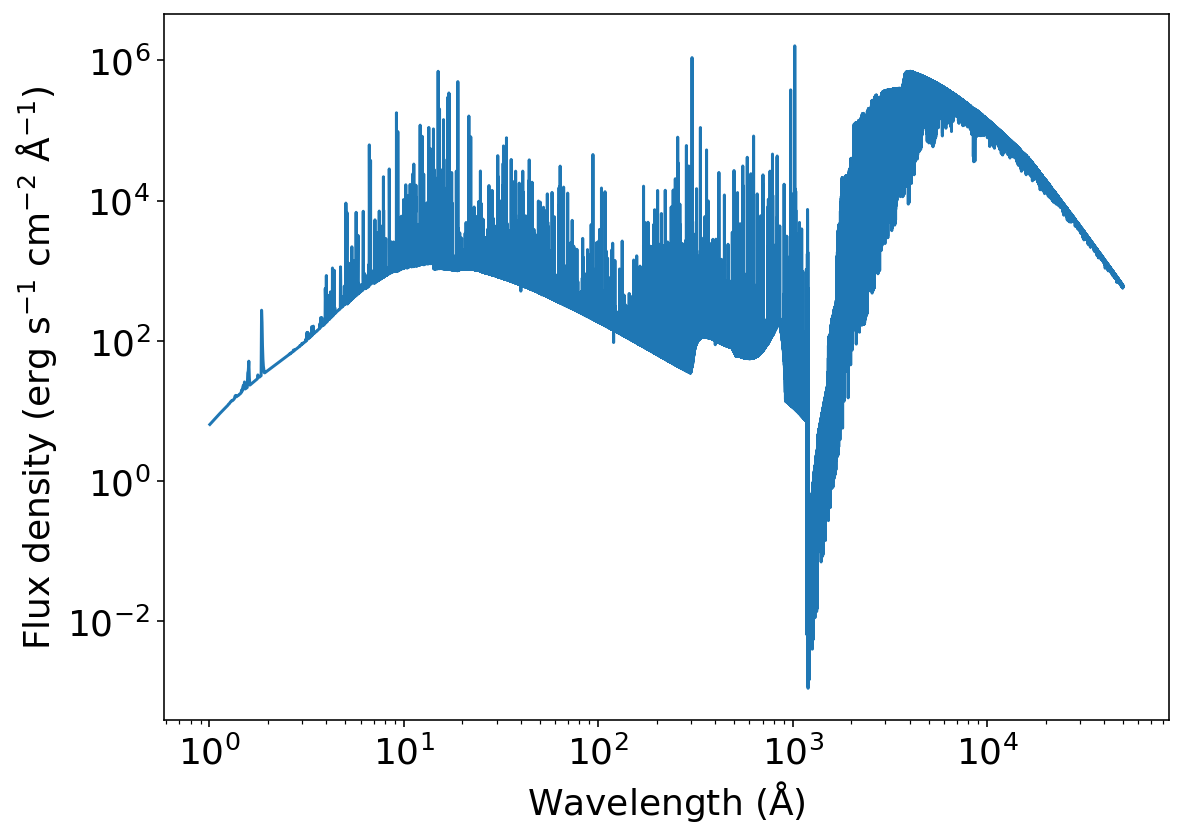

In [18]:
plt.loglog(host_spectrum['wavelength'], host_spectrum['flux_lambda'])
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel(r'Flux density (erg s$^{-1}$ cm$^{-2}$ ${\rm \AA}^{-1}$)')
plt.show()

Before we start fitting the observed data to models, we have to do a few sanity checks and assess if all the moving parts of ``p-winds`` will work well for the configuration you set in the cell above. Most numerical issues are caused when using the ``scipy.integrate`` routines.

We start by assessing if the atmospheric model behaves well.

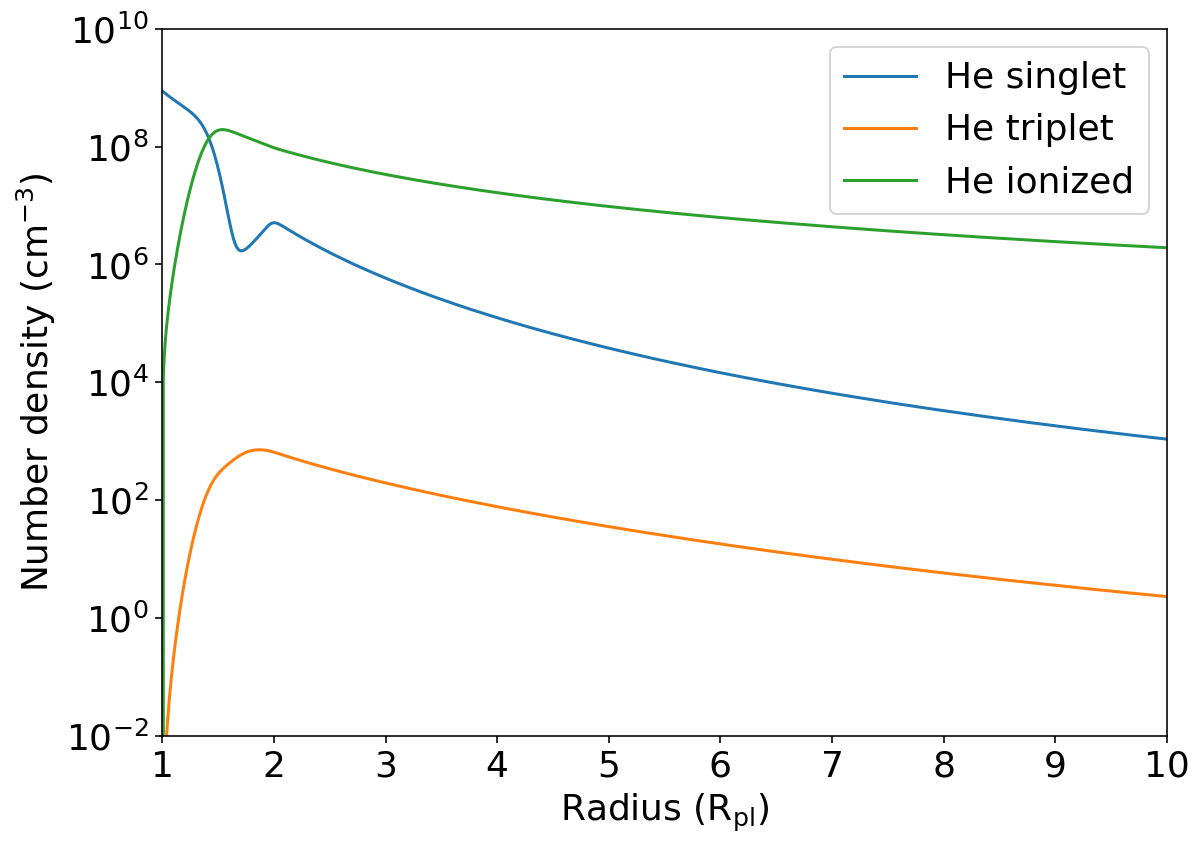

In [19]:
# Calculate the model
def atmospheric_model(theta):
    log_m_dot, log_T = theta
    m_dot = 10 ** log_m_dot
    T = 10 ** log_T
    
    f_r, mu_bar = hydrogen.ion_fraction(r, R_pl, T, h_fraction,
                                m_dot, M_pl, mu_0,
                                spectrum_at_planet=host_spectrum,
                                initial_f_ion=initial_f_ion, 
                                relax_solution=relax_solution,
                                exact_phi=exact_phi, return_mu=True)

    # Update the structure for the revised ion fraction
    updated_mean_f_ion = np.mean(f_r)
    vs = parker.sound_speed(T, mu_bar)
    rs = parker.radius_sonic_point(M_pl, vs)
    rhos = parker.density_sonic_point(m_dot, rs, vs)
    r_array = r * R_pl / rs
    v_array, rho_array = parker.structure(r_array)
    
    # Calculate the helium population
    f_he_1, f_he_3 = helium.population_fraction(r, v_array, rho_array, f_r,
        R_pl, T, h_fraction, vs, rs, rhos,
        spectrum_at_planet=host_spectrum,
        initial_state=initial_f_he, relax_solution=relax_solution)

    # Number density of helium nuclei
    n_he = (rho_array * rhos * he_fraction / (h_fraction + 4 * he_fraction) / m_h)
    
    # Number density distribution of helium
    n_he_1 = f_he_1 * n_he
    n_he_3 = f_he_3 * n_he
    n_he_ion = (1 - f_he_1 - f_he_3) * n_he
    
    # Return the important outputs (number densities [cm ** -3] of helium and 
    # the profile of velocities of the outflow [km / s])
    return n_he_1, n_he_3, n_he_ion, v_array * vs

# Let's test if the model function is working
theta = (log_m_dot_0, log_T_0)
y0 = (initial_f_ion, initial_f_he)
n_he_1, n_he_3, n_he_ion, v_array = atmospheric_model(theta)

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()

Seems to be working fine. Now we do a sanity check for the radiative transfer. There is not a lot of things that can break here, but we do it anyway.

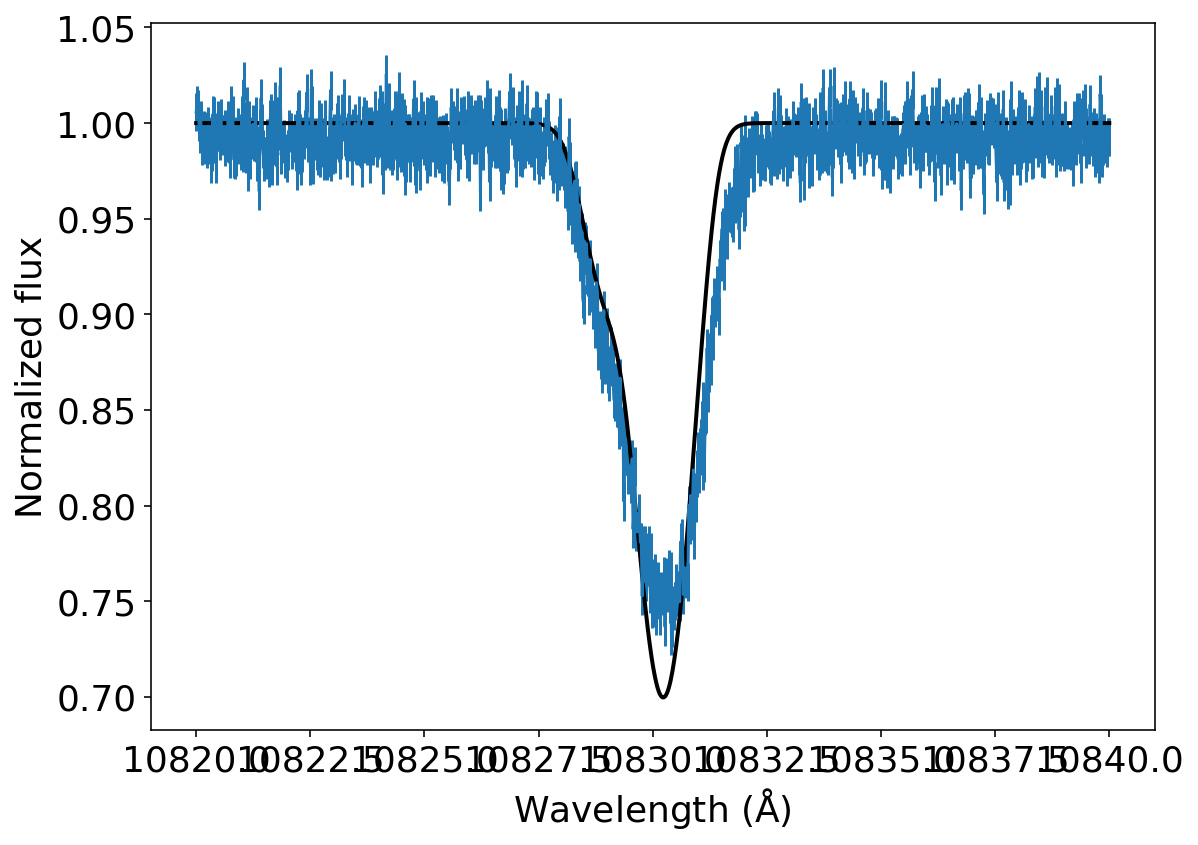

In [20]:
# The transmission spectrum model
def transmission_model(wavelength_array, v_wind, n_he_3_distribution, log_T, v_array):

    # Set up the transit configuration. We use SI units to avoid too many 
    # headaches with unit conversion
    R_pl_physical = R_pl * 71492000  # Planet radius in m
    r_SI = r * R_pl_physical  # Array of altitudes in m
    v_SI = v_array * 1000  # Velocity of the outflow in m / s
    n_he_3_SI = n_he_3_distribution * 1E6  # Volumetric densities in 1 / m ** 3

    # Set up the ray tracing
    f_maps = []
    t_depths = []
    r_maps = []
    for i in range(n_samples):
        flux_map, transit_depth, r_map = transit.draw_transit(
            planet_to_star_ratio,
            impact_parameter=impact_parameter,
            supersampling=supersampling,
            phase=sample_phases[i],
            planet_physical_radius=R_pl_physical,
            grid_size=transit_grid_size
                                   )
        f_maps.append(flux_map)
        t_depths.append(transit_depth)
        r_maps.append(r_map)
    # Do the radiative transfer
    spectra = []

    for i in range(n_samples):
        spec = transit.radiative_transfer_2d(f_maps[i], r_maps[i], 
                                        r_SI, n_he_3_SI, v_SI, w_array, f_array, a_array,
                                        wavelength_array, 10 ** log_T, m_He, bulk_los_velocity=v_wind,
                                            wind_broadening_method='average')
        # We add the transit depth because ground-based observations
        # lose the continuum information and they are not sensitive to
        # the loss of light by the opaque disk of the planet, only
        # by the atmosphere
        spectra.append(spec + t_depths[i])

    spectra = np.array(spectra)
    # Finally we take the mean of the spectra we calculated for each phase
    spectrum = np.mean(spectra, axis=0)
    return spectrum

# Here we divide wl_obs by 1E10 to convert angstrom to m
t_spectrum = transmission_model(wl_obs / 1E10, v_wind_0, n_he_3, log_T_0, v_array)
plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.plot(wl_obs, t_spectrum, color='k', lw=2)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()

Alright, it seems that our first guess was not very good. But we shall soon make this an actual fit. For now, let's write a cascading model that combines both the atmosphere and the radiative transfer. This function will also convolve our predicted spectrum with the instrumental profile.

Also, in the next cell you can do a trial-and-error process to have a better starting guess for the escape rate and the temperature. It took me a minute to find out that the escape rate `1E10` g / s and temperature `6000` K are a much better first guess to fit the data.

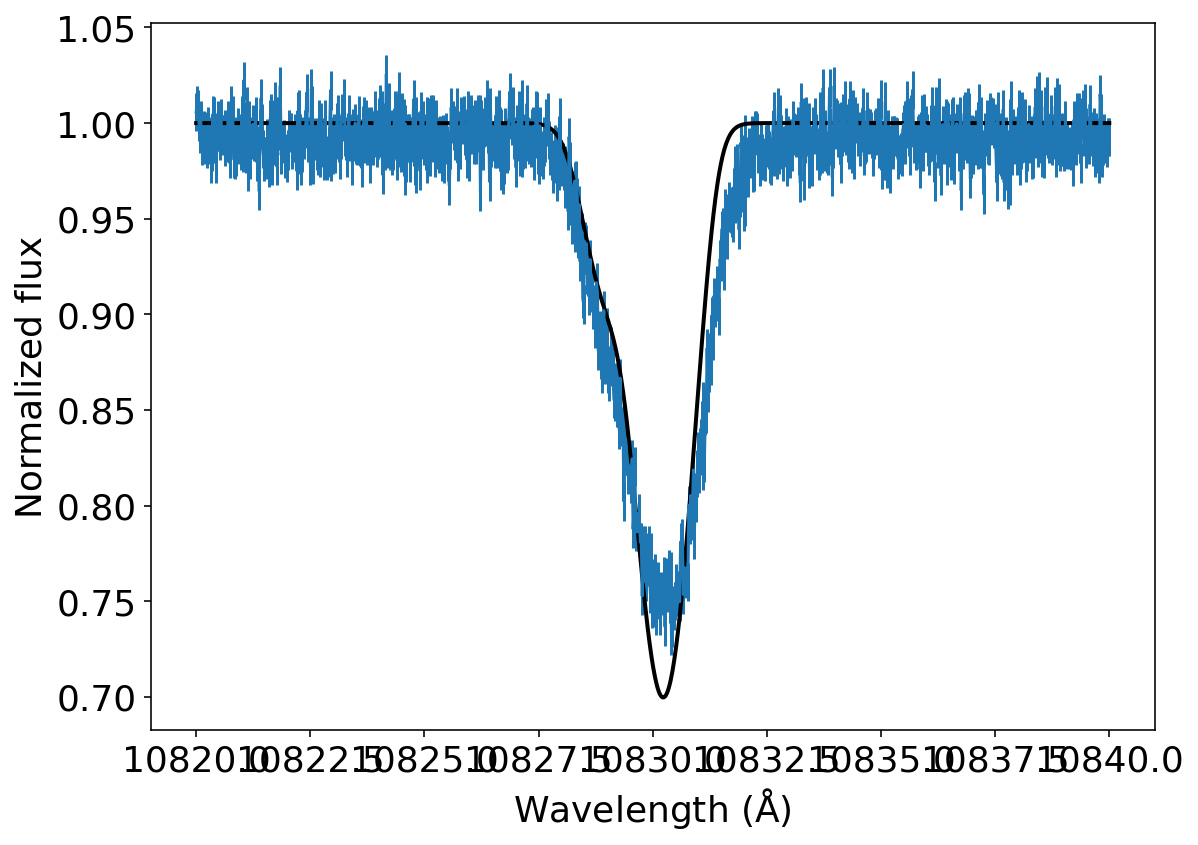

In [21]:
def cascading_model(theta, wavelength_array):
    log_m_dot, log_T, v_wind = theta
    n_he_1, n_he_3, n_he_ion, v = atmospheric_model((log_m_dot, log_T))
    t_spec = transmission_model(wavelength_array, v_wind, n_he_3, log_T, v)
    #t_spec_conv = convolve(t_spec, instrumental_profile, boundary='extend')
    t_spec_conv = t_spec
    return t_spec_conv

# First guess
theta0 = (log_m_dot_0, 
          log_T_0, 
          v_wind_0)

t_spec = cascading_model(theta0, wl_obs / 1E10)

plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.plot(wl_obs, t_spec, color='k', lw=2)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()

Great, it seems that the cascading model is also working well. We will fit it to the observations using a maximum likelihood estimation. The log-likelihood is defined as:

$$
\ln{p(y | x, \sigma, \log{\dot{m}}, \log{T}, v_{\rm wind})} = -\frac{1}{2} \sum_n \left[ \frac{\left(y_n - y_{\rm model}\right)^2}{\sigma^2} + \ln{\left(2\pi \sigma^2 \right)} \right]
$$

We do one sneaky trick in the calculation of log-likelihood here to avoid some numerical issues. The problem is that the solvers, which calculates the steady-state ionization of He, for some reason, can ocassionally become numerically unstable in some very specific cases and lose precision, yielding a `RuntimeError`. These solutions are of no use to us, but we do not want them to stop our optimization. So we discard them by making the log-likelihood function return `-np.inf` in those cases.

In [22]:
def log_likelihood(theta, x, y, yerr):
    try:
        model = cascading_model(theta, x)
        sigma2 = yerr ** 2
        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
    except RuntimeError:
        return -np.inf

With all that set, we use `scipy.optimize.minimize()` to maximize the likelihood of our solution and find the best fit. This calculation takes a few minutes to run on a computer with a 3.1 GHz CPU, so I commented the line that actually does this calculation as to not use the resources of online platforms that compile this notebook and upset the powers that be. But you should try running it in your own computer. 

In some cases you may run into runtime warnings, but the result should be robust. The actual computation time depends on how bad the first guess was, so you will probably save some time if you do a first fit by eye and than optimize it. You can also try changing the `method` option of `minimize()`.

In [24]:
nll = lambda *args: -log_likelihood(*args)
args = (wl_obs / 1E10, f_obs, u_obs)

In [25]:
%time soln = minimize(nll, theta0, args=args, method='Nelder-Mead')
log_mdot_ml, logT_ml, v_wind_ml = soln.x

CPU times: user 1h 15min 45s, sys: 34min 23s, total: 1h 50min 8s
Wall time: 4h 7min 47s


When I started from a very good guess (`m_dot = 2E10`, `T_0 = 6000`, `v_wind_0 = -2000.0`), `minimize()` converges to a best fit solution of $\dot{m} = 4.9 \times 10^{10}$ g s$^{-1}$, $T = 8100$ K, and $v_{\rm wind} = -1.9$ km s$^{-1}$ in about 6 minutes in a 3.1 GHz CPU with four threads.

In [ ]:
theta_ml = (np.log10(4.9E10), np.log10(8100), -1.9E3)

t_spec = cascading_model(theta_ml, wl_obs / 1E10)

plt.errorbar(wl_obs, f_obs, yerr=u_obs)
plt.plot(wl_obs, t_spec, color='k', lw=2)
plt.xlabel(r'Wavelength (${\rm \AA}$)')
plt.ylabel('Normalized flux')
plt.show()